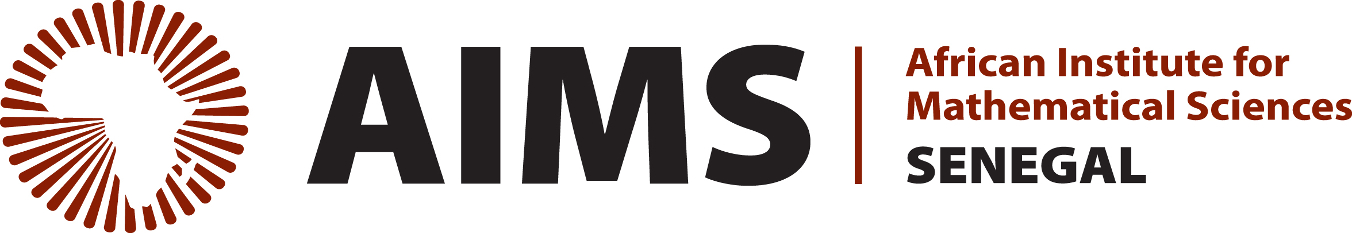
    
#    <center> <b> <span style="color:orange;" >  `AIMS THESIS 2022 : Optimal Trading Algorithms; a Machine Learning Approach ` </span> </b></center>

#### <center> <b> <span style="color:blue;"> Sandra Marion Kam Tsemo  (sandra.m.k.tsemo@aims-senegal.org) </span> </b></center>

#### <center> <b> <span style="color:blue;"> African Institute for Mathematical Sciences (AIMS), Senegal </span> </b></center>

#### <center> <b> <span style="color:blue;"> Supervised by: Professor Moustapha Pemy (mpemy@towson.edu) </span> </b></center>

#### <center> <b> <span style="color:blue;"> Towson University, USA </b></center>

## <center> <b> <span style="color:orange;"> Minimal Shortfall with XOM Intraday data 09-07-2017 </span> </b></center>



In [22]:
# import librairies

import numpy as np
import pandas as pd
import math as m
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats 
import warnings
warnings.filterwarnings('ignore')

In [23]:
# import drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
# import data
mydata = pd.read_csv("/content/drive/MyDrive/Data_project/XOMIntradayOf9-7-2017.csv",index_col = "Trade Time", parse_dates= True)
# description of the top 5 values
mydata.head(5)

,Volume,Price
Trade Time,,
2017-09-07 16:00:00,6278,78.78
2017-09-07 16:00:00,6289,78.78
2017-09-07 16:00:00,6291,78.78
2017-09-07 16:00:00,6341,78.78
2017-09-07 16:00:00,6391,78.78


In [25]:
# description rows and columns
mydata.shape

(1544, 2)

In [16]:
# statistical description
mydata.describe()

,Volume,Price
count,1.544000e+03,1544.000000
mean,4.268017e+06,78.883443
std,1.957989e+06,0.110256
min,6.278000e+03,78.610700
25%,2.805618e+06,78.815000
50%,4.226113e+06,78.890000
75%,5.768875e+06,78.936900
max,9.824104e+06,79.318500


In [17]:
#Converting all values to float for easy 

for i in ["Volume","Price"]:
    mydata[i]=mydata[i].astype(float)
mydata.dtypes

Volume    float64
Price     float64
dtype: object

In [18]:
#Vissually show the stock historical Price and Volume data
import plotly.graph_objects as go
from plotly.subplots import make_subplots
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=mydata.index,y=mydata['Price'],name='Price USD ($)'),secondary_y=False)
fig.add_trace(go.Bar(x=mydata.index,y=mydata['Volume'],name='Volume'),secondary_y=True)
fig.show()

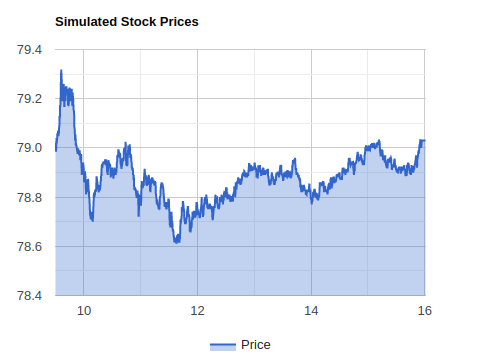

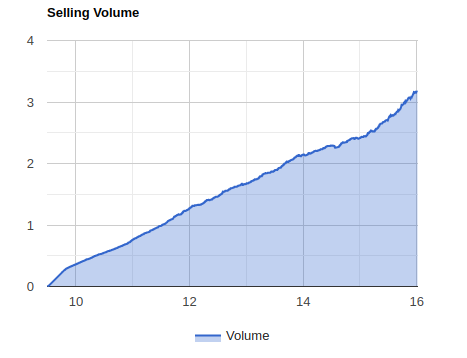

#### Market vwap
$VWAP(\pi) = \dfrac{\sum v_k x_k}{\sum v_k} , ∀ k \in \{0,...,N\}$

In [19]:
# implementation market vwap
def marketVwap(mydata):
        mydata['TradedValue']  = mydata['Volume']*mydata['Price']
        mydata['CumVolume'] = mydata['Volume'].cumsum()
        mydata['CumTradedValue'] = mydata['TradedValue'].cumsum()
        mydata['VWAP'] = mydata['CumTradedValue'] / (mydata['CumVolume'])
        return mydata
        
mydata = mydata.groupby('Trade Time').apply(marketVwap)

In [20]:
# description of the top 5 values
mydata.head(5)

,Volume,Price,TradedValue,CumVolume,CumTradedValue,VWAP
Trade Time,,,,,,
2017-09-07 16:00:00,6278.0,78.78,494580.84,6278.0,494580.84,78.78
2017-09-07 16:00:00,6289.0,78.78,495447.42,12567.0,990028.26,78.78
2017-09-07 16:00:00,6291.0,78.78,495604.98,18858.0,1485633.24,78.78
2017-09-07 16:00:00,6341.0,78.78,499543.98,25199.0,1985177.22,78.78
2017-09-07 16:00:00,6391.0,78.78,503482.98,31590.0,2488660.20,78.78


In [21]:
# visually market vwap
from scipy.interpolate import interp1d
from dataclasses import dataclass
#Market VWAP
import plotly.graph_objects as go
from plotly.subplots import make_subplots
mydata = mydata[1400:1450]
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=mydata.index,y=mydata['VWAP'],name='Market VWAP'),secondary_y=False)
fig.show()

### Model vwap using tracking error


### Dynamic Stock price

\\begin{equation}
\begin{cases}
e_{k+1}=e_k+e_k \mu \tau + e_k \xi_k\sigma\sqrt{\tau} + \lambda m_k + \bar{x}\mu \tau + \bar{x} \sigma \xi_k\sqrt{\tau} \\
e_0=x-\bar{x},
\end{cases}
\end{equation}


where  $  \xi_k \sim \mathcal{N}(0,1)$,  $ \text{        }∀ k \in \{0,...,N\}$

#####Calibration of parameters **stock return** ($\mu$) and **volatility ***($\sigma$) using time series

In [26]:
# Calibration of stock return 𝜇 = r
mydata['Stock_return'] = (mydata['Price'] / mydata['Price'].shift(1)) - 1
mydata.head(5)

,Volume,Price,Stock_return
Trade Time,,,
2017-09-07 16:00:00,6278,78.78,NaN
2017-09-07 16:00:00,6289,78.78,0.0
2017-09-07 16:00:00,6291,78.78,0.0
2017-09-07 16:00:00,6341,78.78,0.0
2017-09-07 16:00:00,6391,78.78,0.0


In [31]:
# most recent stock return value
sreturn = mydata['Stock_return'][20]
print('Recent stock return value is : r = ', sreturn)

Recent stock return value is : r =  0.0002530364372468341


In [32]:
#Stock Historical Return
import plotly.graph_objects as go
from plotly.subplots import make_subplots
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=mydata.index,y=mydata['Stock_return'],name='test'),secondary_y=False)
fig.show()

In [33]:
# Calibration of stock return 𝜎 = sigma
mydata['Volatility'] = np.sqrt(np.abs(mydata['Stock_return']))
mydata.head(5)

,Volume,Price,Stock_return,Volatility
Trade Time,,,,
2017-09-07 16:00:00,6278,78.78,NaN,NaN
2017-09-07 16:00:00,6289,78.78,0.0,0.0
2017-09-07 16:00:00,6291,78.78,0.0,0.0
2017-09-07 16:00:00,6341,78.78,0.0,0.0
2017-09-07 16:00:00,6391,78.78,0.0,0.0


In [34]:
# most recent volatility value
sigma = mydata['Volatility'][3]
print('Recent volatility value is : sigma = ', sigma)

Recent volatility value is : sigma =  0.0


In [35]:
#Stock Historical Return
import plotly.graph_objects as go
from plotly.subplots import make_subplots
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=mydata.index,y=mydata['Volatility'],name='test'),secondary_y=False)
fig.show()

In [36]:
# most recent price value
x = mydata['Price'][0]
print('Recent price value is : x = ', x)

Recent price value is : x =  78.78


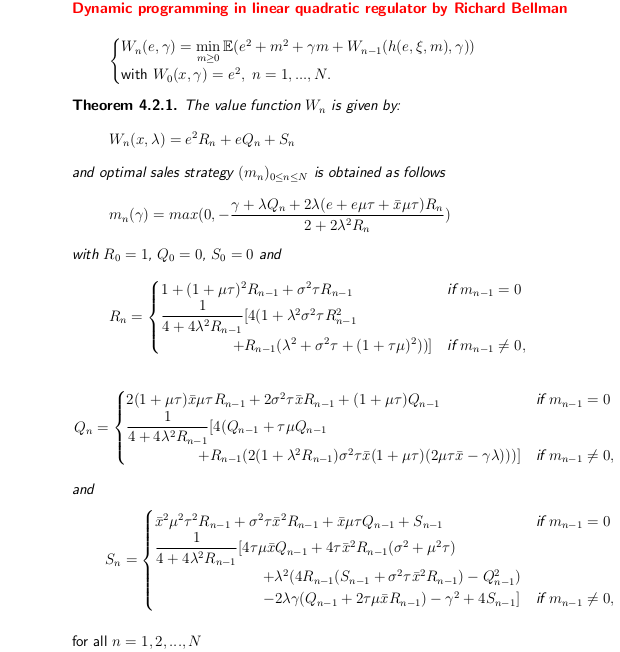

In [3]:
# Define all initial values
M = 2500000  # Total Shares prices
N = 100   # Number of steps.
T = 1   # Expiration time (one day usually)
x = 78.78  # recent value of stock price
r = mu = 0.0002530364 # stock return
sigma =  0.0159071179 # Volatility
lam = -0.000001 #  minimising impact and λ ∈ (−1, 1)
dt = tau = T/N  # time unit --------- Constructing a trajectory of E is then equivalent to sampling from successive 
                #intervals over a uniform mesh {0, dt, 2dt, 3dt, . . . , Ndt}, where dt = 1/N, and N is the number of steps.

C = 1000 # Maximum Sells
gam = 0.001 # Lagrange multiplier
R0 = 1 # initial condition of the function Rn
Q0 = 0 # initial condition of the function Qn
S0 = 0 # initial condition of the function Sn
x_bar = x # arrival price

In [38]:
# implementation shortfall error and plot market vwap and model vwap together

In [ ]:
def Shortfall (R0, Q0, S0, x, N) :
  R = R0
  Q = Q0
  S = S0
  e = x-x_bar
  m_n = max(0,(gam + lam*Q +2*lam*(e+e*r*dt+x_bar*r*dt)*R)/(2+2*(lam**2)*2*R))
  W_n = e**2
  for k in range (N) :
    if m_n[k] != 0 :
      R = 1 + ((1+r*dt)**2)*R + (sigma**2)*dt*R
      Q = 2*(1+r*dt)*x_bar*r*dt + 2*(sigma**2)*dt*x_bar*R + (1+r*dt)*Q
      S = (x_bar**2)*(r**2)*(dt**2)*R + (sigma**2)*dt*(x_bar**2)*R + x_bar*r*dt*Q + S
      W = (e**2)*R + e*Q + S
    else : 
      R = R_n = (1/1+(lam**2)*R)*(1+(lam**2)*(sigma**2)*dt* (R**2)+((lam**2)+(sigma**2)*dt + ((1+ r * dt)**2)*R))
      Q = (1/1+(lam**2)*R)*(Q+r*dt*Q+(2(1+(lam**2)*R*(sigma**2)*dt*x_bar+(1+r*dt)*(2*r*dt*x_bar - gam * lam))*R))
      S =  (1/4+4*(lam**2)*R)*(4*r*dt*x_bar+Q+4*dt*x_bar*R ((sigma**2)+(r**2)*dt)+(lam**2)*(4*(S+(sigma**2)*dt*(x_bar**2)*R)*R-(Q**2))+-2*lam*gam*(Q+2*r*dt*x_bar*R)-(gam**2)+4*S
      W = (e**2)*R + e*Q + S
  return W

shortfall = Shortfall (R0, Q0, S0, x, N)



In [ ]:
def modelVwap(mydata):
        mydata['TradedValue']  = shortfall*mydata['Price']
        mydata['CumTradedValue'] = mydata['TradedValue'].cumsum()
        mydata['VWAP_t'] = mydata['CumTradedValue'] / M
        return mydata
mydata = mydata.groupby('Trade Time').apply(modelVwap)

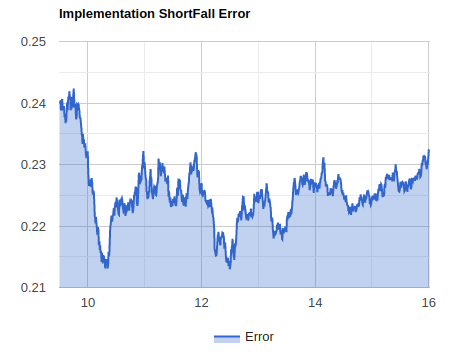

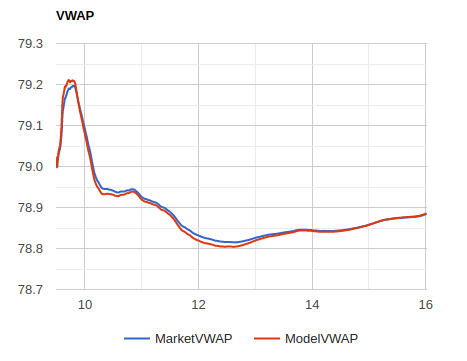

### Comment :

> We observe that on average, our implementation shortfall algorithm is efficient because it beats the market algorithm. And we see that the total volume sold so far is: 5864.67903063892. What we propose as a next step is to hold 0 shares at the recommended price of 79.0340231497251.

#### End Minimal shortfall strategy.